# Pose Estimation Models

## Imports

In [63]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math as m

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error, mean_squared_error

np.set_printoptions(suppress = True)

## Variables

In [2]:
data_path_prefix = "D:/Uni Stuff/IP/Data/"
image_path_prefix = data_path_prefix + "Blimp Images/Raw/image_"

test_split = 0.25

desired_image_size = 16

image_columns = []
colours = {0:"R", 1:"G", 2:"B"}

for i in range(desired_image_size):
    for j in range(desired_image_size):
        for k in range(3):
            image_columns.append(str(i + 1) + " " + str(j + 1) + " " + colours[k])

---

## Data Pre-processing

### CSVs

Load the bounding box and pose csv files and add to dataframes

In [3]:
bbox_data = pd.read_csv(data_path_prefix + "bbox data.csv")

pose_data = pd.read_csv(data_path_prefix + "blimp poses.csv")
y_variables = list(pose_data.columns)

### Images

Load the images from file, crop these by the bounding box and then resize to the desired square image size with padding to preserve aspect ratio. Image data is flattened and added to dataframe.

In [4]:
def cutout_image(image, bbox):
    width = image.shape[1]
    height = image.shape[0]

    center_x = bbox['cent_x'] * width
    center_y = bbox['cent_y'] * height

    bbox_width = bbox['width'] * width
    bbox_height = bbox['height'] * height

    min_x = np.clip(int(center_x - (bbox_width / 2)), 0, width)
    max_x = np.clip(int(center_x + (bbox_width / 2)), 0, width) 

    min_y = np.clip(int(center_y - (bbox_height / 2)), 0, height)
    max_y = np.clip(int(center_y + (bbox_height / 2)), 0, height)

    return image[min_y:max_y, min_x:max_x]

def process_image(image):
    old_size = image.shape[:2]

    size_ratio = float(desired_image_size) / max(old_size)

    new_size = tuple([int(x * size_ratio) for x in old_size])

    resized_image = cv.resize(image, (new_size[1], new_size[0]), interpolation=cv.INTER_AREA)

    delta_w = desired_image_size - new_size[1]
    delta_h = desired_image_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    padded_image = cv.copyMakeBorder(resized_image, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)

    return padded_image

images = pd.DataFrame(columns=image_columns)

for i in range(len(pose_data)):
    img = cv.imread(image_path_prefix + str(i) + ".png")
    cropped = cutout_image(img, bbox_data.iloc[i])
    padded = process_image(cropped)

    images.loc[len(images)] = padded.flatten()

In [7]:
for i in range(5):
    img = cv.imread(image_path_prefix + str(i) + ".png")
    cropped = cutout_image(img, bbox_data.iloc[i])
    padded = process_image(cropped)

    cv.imwrite("D:/Uni Stuff/IP/image_" + str(i) + ".png", padded)

### Splits

Concatenate the bounding box data and image data into one dataframe. Split that and pose data into the training and testing lists.

In [5]:
X = pd.concat([bbox_data, images], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, pose_data, test_size=test_split)

## Cleanup

---

## Deep Learning Stuff

In [56]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6)
  ])

  model.compile(loss = 'mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

  return model

dnn_model = build_and_compile_model(normalizer)

In [57]:
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 772)              1545      
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                49472     
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 6)                 390       
                                                                 
Total params: 55,567
Trainable params: 54,022
Non-trainable params: 1,545
_________________________________________________________________


In [58]:
dnn_history = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 7.0238 - val_loss: 5.8759
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 5.0911 - val_loss: 4.4136
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 3.6915 - val_loss: 3.2101
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 2.7584 - val_loss: 2.5760
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 2.1548 - val_loss: 2.0435
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 1.8190 - val_loss: 1.7833
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 1.6197 - val_loss: 1.7006
Epoch 8/100
188/188 [==============================] - 0s 1ms/step - loss: 1.5157 - val_loss: 1.6039
Epoch 9/100
188/188 [==============================] - 0s 1ms/step - loss: 1.3619 - val_loss: 1.4868
Epoch 10/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2873 - val_lo

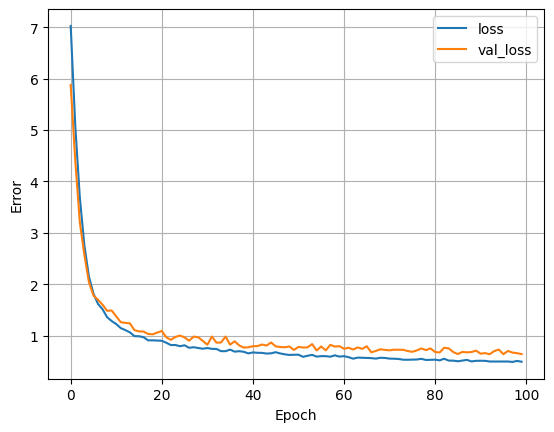

In [59]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(dnn_history)

In [60]:
dnn_model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 858us/step - loss: 0.6633


0.6633106470108032

In [61]:
print("Actual:")
print(y_test)

print("Predicted:")
predictions = dnn_model.predict(X_test)
print(pd.DataFrame(predictions, columns=['pos_x', 'pos_y', 'pos_z', 'rot_x', 'rot_y', 'rot_z']))

Actual:
          pos_x      pos_y      pos_z     rot_x     rot_y     rot_z
190    7.240973   2.744666  -2.183958 -0.077305  0.567997  2.838675
2529  44.223068  26.082565   0.349238 -0.013046 -0.302526  2.420302
6454  55.622398  11.789606  20.757456 -0.025140  0.178323 -2.092536
4614  23.569904  -4.895354  -2.348495  0.100531  0.642779 -0.974271
7366  57.181553  32.510929  -9.903076 -0.110997  0.412872  2.703349
...         ...        ...        ...       ...       ...       ...
4638  22.909243   3.498720  -7.105594  0.020367 -0.740245  2.699666
470   43.601376 -20.658295   8.398165  0.141550 -0.679787 -3.001947
4791  17.448713   0.279786  -6.539343 -0.123772  0.772163  0.393153
4937  69.448288  -1.784993  -2.095498  0.004880 -0.641748  1.776385
2104  37.928856  13.896941 -10.486411  0.101457 -0.494624 -1.480206

[2500 rows x 6 columns]
Predicted:
79/79 [==============================] - 0s 692us/step
          pos_x      pos_y      pos_z     rot_x     rot_y     rot_z
0      7.471494  

In [77]:
def get_rotation_matrix(rot_vec):
    x_matrix = np.matrix([[ 1, 0           , 0],
                          [ 0, m.cos(m.radians(rot_vec[0])),-m.sin(m.radians(rot_vec[0]))],
                          [ 0, m.sin(m.radians(rot_vec[0])), m.cos(m.radians(rot_vec[0]))]])
    
    y_matrix = np.matrix([[ m.cos(m.radians(rot_vec[1])), 0, m.sin(m.radians(rot_vec[1]))],
                          [ 0                , 1, 0 ],
                          [-m.sin(m.radians(rot_vec[1])), 0, m.cos(m.radians(rot_vec[1]))]])
    
    z_matrix = np.matrix([[ m.cos(m.radians(rot_vec[2])), -m.sin(m.radians(rot_vec[2])), 0 ],
                          [ m.sin(m.radians(rot_vec[2])),  m.cos(m.radians(rot_vec[2])), 0 ],
                          [ 0                , 0                 , 1 ]])
    
    return z_matrix * y_matrix * x_matrix

blimp_vertices = np.array([[1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, -1], [-1, -1, 1]])

true_rot_vec = np.array([0, 0, 0])
true_rot = get_rotation_matrix(true_rot_vec)

true_trans = np.array([0, 0, 0])

pred_rot_vec = np.array([0, 0, 0])
pred_rot = get_rotation_matrix(pred_rot_vec)

pred_trans = np.array([1, 1, 1])

total_distance = 0

for vertex_pos in blimp_vertices:
    true_pos = np.matmul(true_rot, vertex_pos) + true_trans
    pred_pos = np.matmul(pred_rot, vertex_pos) + pred_trans

    distance = np.linalg.norm(true_pos - pred_pos)
    total_distance += distance

avg_distance = total_distance / len(blimp_vertices)

In [78]:
print(avg_distance)

1.732050807568877


## Training

### Multilinear Regression

In [8]:
multilinear_model = linear_model.LinearRegression()
multilinear_model.fit(X_train, y_train)

LinearRegression()

### Ridge Regression

In [9]:
ridge_model = linear_model.Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

### Lasso Regression

In [10]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X_train, y_train)

c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+04, tolerance: 3.095e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.345e+03, tolerance: 2.266e+02
  model = cd_fast.enet_coordinate_descent(


Lasso()

### Polynomial Regression

In [10]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train.values)

poly_model = linear_model.LinearRegression()
poly_model.fit(poly_features, y_train)

In [ ]:
print(poly_features)

### Bayesian Regression

In [29]:
bayesian_model = []
bayesian_model = [linear_model.BayesianRidge() for i in range(len(y_variables))]

for i in range(len(y_variables)):
    bayesian_model[i].fit(X_train, y_train[y_variables[i]])

### Gaussian Regression

In [49]:
kernel = RBF()

gaussian_model = []
gaussian_model = [GaussianProcessRegressor(kernel=kernel) for i in range(len(y_variables))]

for i in range(len(y_variables)):
    bayesian_model[i].fit(X_train, y_train[y_variables[i]])

### Support Vector Regression

---

## Evaluating

### Multilinear Regression

Predict outputs of the testing split and determine mean squared and mean absolute errors.

In [15]:
multilinear_predictions = multilinear_model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, multilinear_predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, multilinear_predictions))

mean_squared_error :  43.385313427133305
mean_absolute_error :  3.5946233031205463


In [ ]:
i = 2341

print("Actual:    " + str(y_test.iloc[i].values))
print("Predicted: " + str(multilinear_predictions[i]))

### Ridge Regression

In [16]:
ridge_predictions = ridge_model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, ridge_predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, ridge_predictions))

mean_squared_error :  43.25735661472114
mean_absolute_error :  3.5974812170953823


### Lasso Regression

In [17]:
lasso_predictions = lasso_model.predict(X_test)

print('mean_squared_error : ', mean_squared_error(y_test, lasso_predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, lasso_predictions))

mean_squared_error :  63.16263601347481
mean_absolute_error :  4.36555379872854


### Polynomial Regression

### Bayesian Regression

In [36]:
bayesian_predictions = []
bayesian_predictions = [bayesian_model[i].predict(X_test) for i in range(len(bayesian_model))]

mean_squared_errors = [0] * len(bayesian_predictions)
mean_absolute_errors = [0] * len(bayesian_predictions)

for i in range(len(bayesian_predictions)):
    mean_squared_errors[i] = mean_squared_error(y_test[y_variables[i]], bayesian_predictions[i])
    mean_absolute_errors[i] = mean_absolute_error(y_test[y_variables[i]], bayesian_predictions[i])

print('mean_squared_errors : ', mean_squared_errors)
print('mean_absolute_errors : ', mean_absolute_errors)

print('worst_mean_squared_error : ', max(mean_squared_errors))
print('worst_mean_absolute_error : ', max(mean_absolute_errors))

mean_squared_errors :  [174.70540447615963, 64.32983196345607, 22.608114043835577, 0.007483105411069927, 0.015270915414334826, 1.1324843130903621]
mean_absolute_errors :  [11.091434685967984, 6.2501243924163585, 3.656565108966513, 0.07088285144724372, 0.09333767147060837, 0.6046466527538764]
worst_mean_squared_error :  174.70540447615963
worst_mean_absolute_error :  11.091434685967984


### Gaussian Regression

In [50]:
gaussian_predictions = []
gaussian_predictions = [gaussian_model[i].predict(X_test) for i in range(len(gaussian_model))]

mean_squared_errors = [0] * len(gaussian_predictions)
mean_absolute_errors = [0] * len(gaussian_predictions)

for i in range(len(gaussian_predictions)):
    mean_squared_errors[i] = mean_squared_error(y_test[y_variables[i]], gaussian_predictions[i])
    mean_absolute_errors[i] = mean_absolute_error(y_test[y_variables[i]], gaussian_predictions[i])

print('mean_squared_errors : ', mean_squared_errors)
print('mean_absolute_errors : ', mean_absolute_errors)

print('worst_mean_squared_error : ', max(mean_squared_errors))
print('worst_mean_absolute_error : ', max(mean_absolute_errors))

mean_squared_errors :  [2037.825542655617, 298.36466432742714, 96.98200478024835, 0.010264234077006142, 0.04115380083531885, 3.326177908224425]
mean_absolute_errors :  [40.357642735481264, 13.363598386759124, 7.677266850466887, 0.08751113504250783, 0.17583206218304695, 1.5824390139432392]
worst_mean_squared_error :  2037.825542655617
worst_mean_absolute_error :  40.357642735481264


c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
c:\Users\frase\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without f

---

## Tuning

### Ridge Regression

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)

search = GridSearchCV(ridge_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

results = search.fit(X_train, y_train)

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)